<a href="https://colab.research.google.com/github/ebatty/MathToolsforNeuroscience/blob/jupyterbook/Week3/Week3Tutorial2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial 2

**Dynamical Systems I, Discrete Dynamics & Eigenstuff**

 Imports


In [5]:
# @markdown Imports

# Imports
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import scipy.linalg
from matplotlib.animation import FuncAnimation
import ipywidgets as widgets  

# Plotting parameters
from IPython.display import HTML
plt.rcParams["animation.html"] = "jshtml"
matplotlib.rcParams.update({'font.size': 22})

 Plotting functions


In [6]:
# @markdown Plotting functions
your_theme = 'white'
if your_theme == 'dark':  
  plt.style.use(['dark_background'])
  classic = 'w'
else:
  classic = 'k'

def plot_eig_vec_transform(W):
  vec_names = ['a', 'b','c','d','e','f','g', 'h']

  _, vecs = np.linalg.eig(W)
  vecs = vecs.T

  fig, axes = plt.subplots(1, 2, figsize=(10, 5))
  colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

  for i in range(2):
    axes[i].set(xlim=[-3.5, 3.5], ylim=[-3.5,3.5])
    axes[i].axis('Off')
    axes[i].plot([0, 0], [-3.5, 3.5], classic, alpha=.4)
    axes[i].plot([-3.5, 3.5], [0, 0], classic, alpha=.4)

  for i_vec, vec in enumerate(vecs):    
    axes[0].arrow(0, 0, vec[0], vec[1], head_width=.2, facecolor=colors[i_vec], edgecolor=colors[i_vec], length_includes_head=True)
    axes[0].annotate(vec_names[i_vec], xy=(vec[0]+np.sign(vec[0])*.15, vec[1]+np.sign(vec[1])*.15), color=colors[i_vec])

    transformed_vec = np.matmul(W, vec)
    axes[1].arrow(0, 0, transformed_vec[0], transformed_vec[1], head_width=.2, facecolor=colors[i_vec], edgecolor=colors[i_vec], length_includes_head=True)
    axes[1].annotate(vec_names[i_vec], xy=(transformed_vec[0]+np.sign(transformed_vec[0])*.15, transformed_vec[1]+np.sign(transformed_vec[1])*.15), color=colors[i_vec])

  axes[0].set_title('Before')
  axes[1].set_title('After')
def plot_circuit_responses(u, W, eigenstuff = False, xlim='default', ylim='default', magnitude=None):
    fig, ax = plt.subplots(1, 1, figsize=(10,10))

    # Set up axis limits
    if xlim =='default':
      extreme = np.maximum(np.abs(np.min(u)), np.max(u))
      xlim = [- extreme, extreme]
    if ylim == 'default':
      extreme = np.maximum(np.abs(np.min(u)), np.max(u))
      ylim = [- extreme, extreme]

    # Set up look
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    cs = plt.rcParams['axes.prop_cycle'].by_key()['color']*10
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

    # Set up tracking textz
    tracker_text = ax.text(.5, .9, "", color='w', fontsize=20, verticalalignment='top', horizontalalignment='left', transform=ax.transAxes)

    # Plot eigenvectors
    if eigenstuff:
      eigvals, eigvecs = np.linalg.eig(W)

      if np.abs(eigvals[0]) < np.abs(eigvals[1]):
        lc1 = 'c'
        lc2 = 'g'
      else:
        lc1 = 'g'
        lc2 = 'c'

      ax.plot(np.arange(-10000, 10000)*eigvecs[0, 0], np.arange(-10000, 10000)*eigvecs[1, 0],lc1, alpha=.5, label = r'$\bar{v}_1$')
      ax.plot(np.arange(-10000, 10000)*eigvecs[0, 1], np.arange(-10000, 10000)*eigvecs[1, 1], lc2, alpha=.5, label = r'$\bar{v}_2$')

      ax.legend()

    # Set up scatter
    cmap = plt.cm.coolwarm
    norm = plt.Normalize(vmin=0, vmax=u.shape[1])
    ax.plot(u[0,:], u[1, :], alpha=.4, zorder = 0)
    scatter = ax.scatter(u[0, :], u[1, :], alpha=1, c = cmap(norm(np.arange(u.shape[1]))), zorder = 1)


    ax.set(xlabel = 'Neuron 1 Firing Rate ($u_1$)', ylabel = 'Neuron 2 Firing Rate ($u_2$)', title = f'Neural firing over time \n Magnitude={magnitude:.2f}')
    
    fig.colorbar(matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap),
                ax=ax, label = 'Time step')
    

 Helper functions


In [7]:
# @markdown Helper functions

def get_eigval_specified_matrix(target_eig):
  """Generates matrix with specified eigvals

    Args:
      target_eig (list): list of target eigenvalues, can be real or complex,
              should be length 2 unless you desire repeated eigenvalues
              with the same eigenvector, in which case length 1

    Returns:
      ndarray: 2 x 2 matrix with target eigvals

  """

  # Set up two eigenvectors
  V = np.array([[1, 1], [-1, 1]]).astype('float')
  for i in range(2):
    V[:,i] = V[:,i]/np.linalg.norm(V[:,i])

  # Get matrix with target eigenvalues
  if type(target_eig[0]) == int or type(target_eig[0]) == float:

    if len(target_eig) == 2: # distinct eigvecs (not necessarily distinct eigvals)

        D = np.diag(target_eig)
        A = V @ D @ np.linalg.inv(V)

    else: # repeated with same vec
      summed = 2*target_eig[0]

      a = summed-3
      d = 3
      bc = target_eig[0]**2 - a*d
      factors = [n for n in range(1, bc+ 1) if bc % n == 0]
      b = factors[int(np.floor(len(factors)/2))]
      c = bc/-b

      A = np.array([[a, b], [c, d]])

  elif type(target_eig[0]) == complex:

      C = [np.real(V[:,0]), np.real(V[:,1])]
      B = np.array([[np.real(target_eig[0]), np.imag(target_eig[0])], [-np.imag(target_eig[0]), np.real(target_eig[0])]]).squeeze()
      A = C @ B @ np.linalg.inv(C)

  return A

# Exercise 1: Complex computations

We saw in Video 3.3 that eigenvalues can be complex - let's convince ourselves of this. Consider the following rotation matrix:

$$B = 
\begin{bmatrix}
0 & -1 \\
1 & 0 \\
\end{bmatrix} $$


## A) 
Calculate the eigenvalues of this matrix using $det(B - \lambda I)$ = 0 to solve for $\lambda$.

$$B - \lambda I = 
\begin{bmatrix}
-\lambda & -1 \\
1 & -\lambda \\
\end{bmatrix} $$

$$det (B - \lambda I) = \lambda^2 + 1 = 0$$

$$\lambda = \sqrt{-1}$$

$$\lambda = \pm i$$

## B) 

Why does it make sense intuitively that a rotation has no real eigenvalues? Think about how space is transformed

Your answer here

# C)

Copy and paste your circuit implementation function from Tutorial 1 Exercise 3B below. 

You will then in the next cell enable a demo. It's similar to what you played with in Tutorial 1 but now you can specify complex eigenvalues. If a 2-D matrix has any complex eigenvalues, one has to be r + cj, and the other r-cj, where r is the real part and c is the complex part. You can control r and c in the interactive demo.

The magnitude of a complex number is $(r^2+c^2)^{0.5}$. I report the magnitude of the complex eigevalues in the title of the plot.

- What happens to the neural activity trajectory if the magnitude of the complex eigenvalues is 1?
- What happens if it is greater than 1?
- What happens if it is less than 1?

In [10]:
def circuit_implementation(W, u0, T):
  """ Simulate the responses of N neurons over time given their connections

  Args:
    W (ndarray): weight matrix of synaptic connections, should be N x N
    u0 (ndarray): initial condition or input vector, should be N,
    T (scalar): number of time steps to run simulation for

  Returns:
    u (ndarray): the neural responses over time, should be N x T

  """

  # Compute the number of neurons
  N = W.shape[0] 

  # Initialize empty response array and initial condition
  u = np.zeros((N, T))
  u[:, 0]  = u0

  # Loop over time steps and compute u(t+1), store in correct column of u
  for t in range(1,T):
      u[:,t]=W @ u[:,t-1]
  return u

 Execute this cell to enable the widget (there is a small lag so be patient after changing sliders)


In [11]:
# @markdown Execute this cell to enable the widget (there is a small lag so be patient after changing sliders)
real_part = widgets.FloatSlider(value=0.6, min=0.2, max=2, step=0.2)
complex_part = widgets.FloatSlider(value=0.8, min=0.2, max=2, step=0.2)
u0_1 = widgets.FloatSlider(value=1, min=-5, max=5, step=0.2)
u0_2 = widgets.FloatSlider(value=2, min=-5, max=5, step=0.2)

# def update_range(*args):
#     eigenvalue2.max = eigenvalue1.value - 0.2
# eigenvalue1.observe(update_range, 'value')


def plot_system(real_part, complex_part, u0_1, u0_2):

  # Get initial condition
  u0 = np.array([u0_1, u0_2])

  eigval1 = complex(real_part, complex_part)
  eigval2 = complex(real_part, -complex_part)
  # Get weight matrix with specified eigenvalues
  W = get_eigval_specified_matrix([eigval1, eigval2])

  # Get neural activities
  u = circuit_implementation(W, u0, 50)

  # # Visualize neural activities
  magnitude = np.sqrt(real_part**2 + complex_part**2)
  plot_circuit_responses(u, W, eigenstuff = False, xlim = [-15, 15], ylim = [-15, 15], magnitude = magnitude)

widgets.interact(plot_system, real_part = real_part, complex_part = complex_part, u0_1 = u0_1, u0_2 = u0_2)

interactive(children=(FloatSlider(value=0.6, description='real_part', max=2.0, min=0.2, step=0.2), FloatSlider…

<function __main__.plot_system(real_part, complex_part, u0_1, u0_2)>

# (Optional) Exercise 2: Owls

This exercise is based on one in the Linear Algebra textbook by David Lay.

Researchers studied the population of spotty owls in the Pacific northwest. For a given year $k$, they describe the population by the number of females in the juvenile ($j_k$), subadult ($s_k$), and adult ($a_k$) stages. Within a year, a juvenile owl would be reclassified as a subadult owl, and a subadult owl would age into being an adult owl.

Based on the average birth rate per owl pair, they know that the number of new juvenile females in year $k+1$ will be .33 times the number of adult females in the previous year ($a_k$). 18% of the juveniles survive to become subadults the next year, 71% of the subadults survive to become adults the next year, and 94% of adults stay alive to be adults next year.

## A) Dynamical system formulation

Write out a discrete dynamical system (of the type $x_{t+1} = Wx_t$ to study the evolution of the spotty owl population given all of this information.

$$
\begin{bmatrix}
j_{k+1} \\
s_{k+1} \\
a_{k+1} \\
\end{bmatrix} = 
\begin{bmatrix}
0 & 0 & 0.33 \\
0.18 & 0 & 0 \\
0 & 0.71 & 0.94 \\
\end{bmatrix}
\begin{bmatrix}
j_{k} \\
s_{k} \\
a_{k} \\
\end{bmatrix}
$$

## B) Predicting the future

With these stats, will the spotty owl become extinct in the future? Explain your answer.

Answer this by looking at the eigenvalues and eigenvectors of $W$, not through simulation (although you can use simulation to check your intuitions) .

In [99]:
W = np.array([[0, 0, 0.33], [0.18, 0 ,0], [0 ,0.71, 0.94]])

l,v=np.linalg.eig(W)

for val in l:
    print(f'lambda = {val} ; mag = {np.linalg.norm(val)}')

lambda = (-0.021796369882399774+0.20591848046997355j) ; mag = 0.207068834784748
lambda = (-0.021796369882399774-0.20591848046997355j) ; mag = 0.207068834784748
lambda = (0.9835927397647998+0j) ; mag = 0.9835927397647998


#### Overall population decays over time, given that the dominant magnitude is less than 1. 

In [108]:
def simulate(W,years):
    # Initial population: 100 juveniles, 50 subadults, 200 adults
    x = np.array([100, 50, 200])
    
    # Simulate 
    history = [x.copy()]
    
    for k in range(years):
        x = W @ x
        history.append(x.copy())
    
    history = np.array(history)
    
    # Plot
    plt.figure(figsize=(10, 6))
    plt.plot(history[:, 0], label='Juveniles')
    plt.plot(history[:, 1], label='Subadults')
    plt.plot(history[:, 2], label='Adults')
    plt.xlabel('Year')
    plt.ylabel('Population')
    plt.title('Spotty Owl Population Over Time')
    plt.legend()
    plt.show()


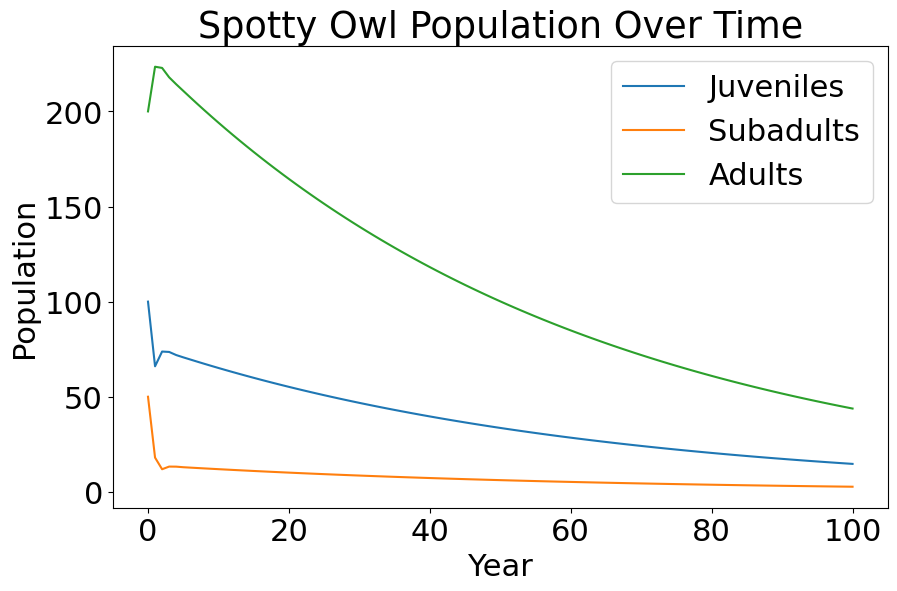

array([14.69169079,  2.68861718, 43.78981937])

In [101]:
simulate(W,100)

## C) Hope for the future

The 18% number for survival of juveniles to subadults is pretty low, partly because there is a lot of cutting of trees in their forest habitats, increasing the likelihood that a predator will see and eat them (since they can't hide amongst the trees). 

If new trees could be reintroduced and the number of juveniles surviving to subadulthood the next year was upped to 30%, would the spotty owl go extinct? Explain your answer.

In [102]:
W = np.array([[0, 0, 0.33], [0.30, 0 ,0], [0 ,0.71, 0.94]])

l,v=np.linalg.eig(W)

for val in l:
    print(f'lambda = {val} ; mag = {np.linalg.norm(val)}')

lambda = (-0.03451832167755315+0.26166579514354776j) ; mag = 0.26393276204279786
lambda = (-0.03451832167755315-0.26166579514354776j) ; mag = 0.26393276204279786
lambda = (1.0090366433551066+0j) ; mag = 1.0090366433551066


#### Overall population increases over time, given that the dominant magnitude is greater than 1. 

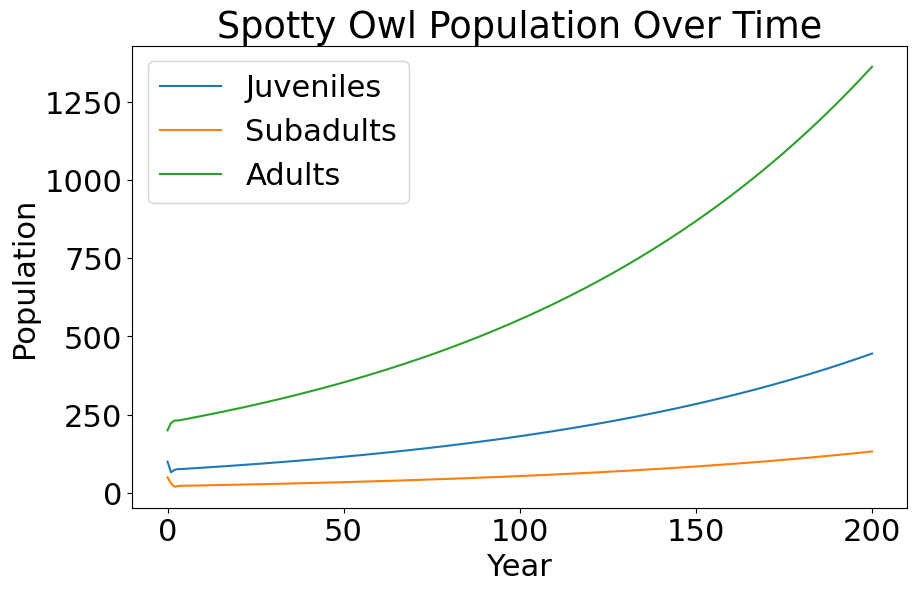

array([ 445.35868442,  132.41105386, 1361.76736974])

In [103]:
simulate(W,200)

## D) Predicting owl life-stage distribution

In this better world where the number of juveniles surviving to subadulthood is 30%, not 18%, what would the proportion of adults to juveniles be after many years? You should be able to answer this again by just looking at the eigenvalues/eigenvectors

#### After several years the population converges to the scaled version of the dominant eigenvector

$${x_k}^t = c \cdot \lambda^t \cdot v_{dominant}$$

$${j_k}^t = c \cdot \lambda^t \cdot v_{dominant}[0]$$
$${a_k}^t = c \cdot \lambda^t \cdot v_{dominant}[2]$$

$$\frac{{a_k}^t} {{j_k}^t} = \frac{v_{dominant}[0]$$

In [104]:
# Find dominant eigenvalue index
dom_idx = np.argmax(np.abs(l))

# Get corresponding eigenvector
v_dom = v[:, dom_idx]

print("Dominant eigenvector:", v_dom)

Dominant eigenvector: [0.3095242 +0.j 0.09202566+0.j 0.94642805+0.j]


In [105]:
#ratio of adult to juveniles
v_dom[2]/v_dom[0]

np.complex128(3.0576867980457765+0j)